Mario's clustering code, commented for my edification, and altered to do my bidding.

In [136]:
#These lines set up inline plotting, and apply a standard size
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'size': 22})

In [137]:
#Define values corresponding to certain "epoch_millis" timestamps
six_hours = 3600*6*1000
four_hours = 3600*4*1000
eight_hours = 3600*8*1000
twelve_hours = 2*six_hours
twenty_hours = 3600*20*1000
thirty_hours = 3600*30*1000

In [166]:
_src = 'CERN-PROD*'
_dst = 'BNL*'

In [167]:
#define base query for Kibana

queryForm="""{
  "size": 500,
  "sort": [
    {
      "@timestamp": {
        "order": "desc",
        "unmapped_type": "boolean"
      }
    }
  ],
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "analyze_wildcard": true,
          "lowercase_expanded_terms": false,
          "query": "event_type:%s AND payload.src-rse:%s AND payload.dst-rse:%s"
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "range": {
                "@timestamp": {
                  "gte": %s,
                  "lte": %s,
                  "format": "epoch_millis"
                }
              }
            }
          ],
          "must_not": []
        }
      }
    }
  },
  "highlight": {
    "pre_tags": [
      "@kibana-highlighted-field@"
    ],
    "post_tags": [
      "@/kibana-highlighted-field@"
    ],
    "fields": {
      "*": {}
    },
    "require_field_match": false,
    "fragment_size": 2147483647
  },
  "fields": [
    "*",
    "_source"
  ],
  "script_fields": {},
  "fielddata_fields": [
    "@timestamp"
  ]
}"""

In [168]:
import elasticsearch
from elasticsearch import Elasticsearch, helpers

#Set host and port
es = Elasticsearch([{'host': 'atlas-kibana.mwt2.org',
                     'port': 9200}])

In [169]:
# current_time - epochs in milliseconds

import time, math


current_time = int(math.ceil(time.time() * 1000))
print(current_time)

1467311464365


In [170]:
from datetime import datetime

#Create function that loads a chunk of data in, based on source, destination, and start- and end-times
def load_chunk(qry):
    
    #Initialize
    data = []
    
    #Use query to get data
    scanner = helpers.scan(client=es, query=qry, scroll='1m', index="rucio-events*", timeout="1m")
    
    #for each scanner value
    for hit in scanner:
        data.append((hit['_source']['payload']['file-size']/1000))
    data = np.asarray(data)
    return data

In [171]:

queryQueued = queryForm%("transfer-queued",_src, _dst, current_time-thirty_hours, current_time)
queryFailed = queryForm%("transfer-failed",_src, _dst, current_time-thirty_hours, current_time)
queryWaiting = queryForm%("transfer-waiting",_src, _dst, current_time-thirty_hours, current_time)
queryDone = queryForm%("transfer-done",_src, _dst, current_time-thirty_hours, current_time)

In [172]:
dataQueued = load_chunk(queryQueued)
print("transfer-queued complete.")
if len(dataQueued) == 0:
    print('No data for transfer-queued in this time range.')
dataFailed = load_chunk(queryFailed)
print("transfer-failed complete.")
if len(dataFailed) == 0:
    print('No data for transfer-failed in this time range.')
dataWaiting = load_chunk(queryWaiting)
print("transfer-waiting complete.")
if len(dataWaiting) == 0:
    print('No data for transfer-waiting in this time range.')
dataDone = load_chunk(queryDone)
print("transfer-done complete.")
if len(dataDone) == 0:
    print('No data for transfer-done in this time range.')
    
print(dataDone.shape)

transfer-queued complete.
transfer-failed complete.
transfer-waiting complete.
transfer-done complete.
No data for transfer-queued in this time range.
No data for transfer-waiting in this time range.
(81040,)


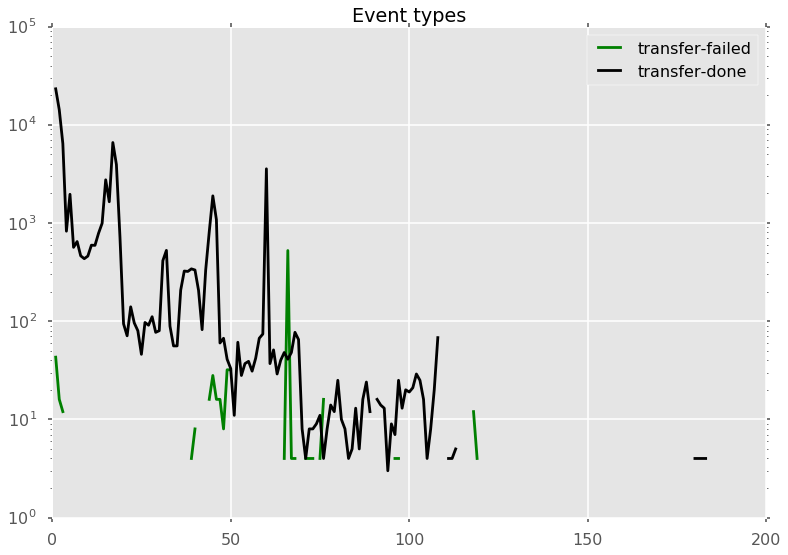

In [175]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import numpy as np
import datetime as dt
plt.style.use('ggplot')
plt.style.use('seaborn-poster')

num = 200
queuedHist,_ = np.histogram(dataQueued,bins=num)
failedHist,_ = np.histogram(dataFailed,bins=num)
waitingHist,_ = np.histogram(dataWaiting,bins=num)
doneHist,bin = np.histogram(dataDone,bins=num)


plt.subplot(111)
if len(dataQueued) != 0:
    plt.semilogy(np.arange(1,num+1),queuedHist,'r-',label='transfer-queued')
if len(dataFailed) != 0:
    plt.semilogy(np.arange(1,num+1),failedHist,'g-',label='transfer-failed')
if len(dataWaiting) != 0:
    plt.semilogy(np.arange(1,num+1),waitingHist,'b-',label='transfer-waiting')
if len(dataDone) != 0:
    plt.semilogy(np.arange(1,num+1),doneHist,'k-',label='transfer-done')
plt.title('Event types')
plt.legend()
plt.show()
#(dhist,binEdges) = np.histogram(data,bins=30)

#binHalfWidth = (binEdges[1] - binEdges[0])/2.
#binCenters = np.zeros(len(binEdges) - 1)

#for i in range(len(binEdges)-1):
#    binCenters[i] = binEdges[i] + binHalfWidth 

   
#dates = mdate.epoch2num(dates)



#secs = matplotlib.dates.epoch2num(data)

#fig,ax = plt.subplots()
#ax.plot_date(secs,)


(array([0]),)

IGNORE BELOW FOR NOW.

In [8]:
def load_data(src, dst, number_of_pieces, piece_length):
    data = {}
    if es.ping():
        for i in range(1, number_of_pieces):
            for j in range (0, 10):
                try:
                    chunk = load_chunk(src, dst, current_time - i*piece_length, current_time - (i-1)*piece_length)
                    data[current_time - (i-1)*piece_length] = chunk
                    break
                except ConnectionTimeout:
                    if j == 10:
                        print("Can't load data after 10 tryouts")
                    continue
    else:
        print("Can't connect ElasticSearch cluster")
    return data

In [9]:
import numpy as np

import time
import datetime
from datetime import timedelta

from scipy.signal import argrelextrema

def get_clusters(data, hist_bins=10):
    clusters = {}
    for key in data.keys():
        r = []
        #hist_bins (10 by defauls as histogram's)
        a, b = np.histogram(data[key], bins = hist_bins)
        #local extremums
        maxm = argrelextrema(a, np.greater)  
        minm = argrelextrema(a, np.less)
        for j in range(0, len(minm[0])):
            r.append([])
            if minm[0][j] == minm[0][0]:
                for d in data[key]:
                    if d < b[minm[0][j]]:
                        r[j].append(d)
            else:
                for d in data[key]:
                    if d < b[minm[0][j]] and d > b[minm[0][j-1]]:
                        r[j].append(d)
        clusters[key] = r
    #code below is used for preparing data for plots: boxplots' positions, labels, etc.
    positions = {}
    keys_list = list(sorted(clusters.keys()))
    for i in range(0, len(keys_list)):
        pos = []
        for cluster in clusters[keys_list[i]]:
            pos.append(i)
        positions[keys_list[i]] = pos
    d = []
    p = []
    for key in sorted(clusters.keys()):
        for c in clusters[key]:
            d.append(c)
        for pos in positions[key]:
            p.append(pos)
    labels = []
    for key in sorted(clusters.keys()):
        labels.append(datetime.datetime.fromtimestamp(key / 1000))
    return clusters, d, p, labels

In [10]:
data7d = load_data(_src, _dst, 3*7, 2*four_hours)

In [20]:
clusters, d, p, labels = get_clusters(data7d, 20)

AttributeError: type object 'datetime.datetime' has no attribute 'datetime'

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

style.use('ggplot')
style.use('seaborn-poster')

fig = plt.figure(figsize=(17,17))
ax = fig.add_subplot(111)
a = ax.boxplot(d, positions=p)
b = plt.xticks(arange(21), labels, rotation='vertical')